In [ ]:
import os
from google.colab import drive
# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Dataset

In [ ]:
import torch
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import h5py
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from rpn import *
from dataset import *
import matplotlib.patches as patches
import pdb
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook, trange

In [ ]:
imgs_path = '/content/gdrive/My Drive/hw3_mycocodata_img_comp_zlib.h5'
masks_path = '/content/gdrive/My Drive/hw3_mycocodata_mask_comp_zlib.h5'
labels_path = '/content/gdrive/My Drive/hw3_mycocodata_labels_comp_zlib.npy'
bboxes_path = '/content/gdrive/My Drive/hw3_mycocodata_bboxes_comp_zlib.npy'
paths = [imgs_path, masks_path, labels_path, bboxes_path]
# load the data into data.Dataset
dataset = BuildDataset(paths)
# build the dataloader
# set 20% of the dataset as the training data
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)
batch_size = 2
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_loader = train_build_loader.loader()
test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

# Histogram Plot

In [ ]:
bounding_boxes = np.load('/content/gdrive/My Drive/hw3_mycocodata_bboxes_comp_zlib.npy', allow_pickle=True)

In [ ]:
#Scaling the bounding box 
for i in range(len(bounding_boxes)):
  if len(bounding_boxes[i])> 1:
    bounding_boxes[i][0][0]=bounding_boxes[i][0][0]* (800/300)
    bounding_boxes[i][0][1]=bounding_boxes[i][0][1]* (1066/400) + 11
    bounding_boxes[i][0][2]=bounding_boxes[i][0][2]* (800/300)   
    bounding_boxes[i][0][3]=bounding_boxes[i][0][3] *(1066/400) + 11 
    bounding_boxes[i][1][0]=bounding_boxes[i][1][0]* (800/300)
    bounding_boxes[i][1][1]=bounding_boxes[i][1][1]* (1066/400) + 11
    bounding_boxes[i][1][2]=bounding_boxes[i][1][2]* (800/300)   
    bounding_boxes[i][1][3]=bounding_boxes[i][1][3] *(1066/400) + 11 
  else:
    bounding_boxes[i]=bounding_boxes[i].squeeze(0)
    bounding_boxes[i][0]=bounding_boxes[i][0]* 2.67
    bounding_boxes[i][1]=bounding_boxes[i][1]* 2.665 + 11
    bounding_boxes[i][2]=bounding_boxes[i][2]* 2.67   
    bounding_boxes[i][3]=bounding_boxes[i][3] * 2.665 + 11
bboxes_height=[]
bboxes_width=[]
#Takes care of the 2 bounding box condition and single bounding box condition
for i in range(len(bounding_boxes)):
  if (len(bboxes[i])==2):
    bboxes_width.append(bounding_boxes[i][0][2]-bounding_boxes[i][0][0])
    bboxes_height.append(bounding_boxes[i][0][3]-bounding_boxes[i][0][1])
    bboxes_width.append(bounding_boxes[i][1][2]-bounding_boxes[i][1][0])
    bboxes_height.append(bounding_boxes[i][1][3]-bounding_boxes[i][1][1])
  else:
    bboxes_width.append(bounding_boxes[i][2]-bounding_boxes[i][0])
    bboxes_height.append(bounding_boxes[i][3]-bounding_boxes[i][1])
aspect=np.asarray(bboxes_width)/ np.asarray(bboxes_height)
scale=(np.asarray(bboxes_height) * np.asarray(bboxes_width))**0.5

[0.6906115]


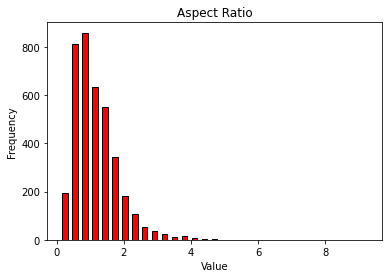

[254.22453]


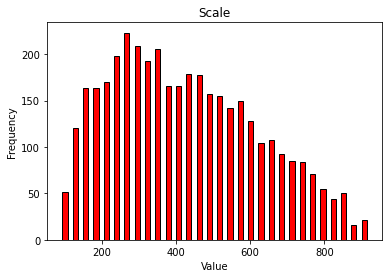

In [ ]:
y,x,_=plt.hist(x=aspect,bins=31,color = "red", ec="black", rwidth=0.55)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Aspect Ratio')
print( x[np.where(y == y.max())])
plt.show()
y1,x1,_=plt.hist(x=scale,bins=30,color = "red", ec="black", rwidth=0.5)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Scale')
print( x1[np.where(y1 == y1.max())])
plt.show()

## Testing with test cases

### Loss testing

In [ ]:
#Loss Test Case
rpn_net = RPNHead()
loss = torch.load('/content/loss_test_1.pt')
x,y,z = rpn_net.compute_loss(loss['clas_out'],loss['regr_out'],loss['targ_clas'],loss['targ_regr'],1, loss['effective_batch'])
print("Regression Loss",y," ","Class",x, z )
print("Loss Regression ",loss['loss_r'], " ","Loss Classification",loss['loss_c'])

Target torch.Size([13600, 4])
Actual torch.Size([13600, 4])
Positive Indices <class 'torch.Tensor'>
subsample_regr_out torch.Size([600, 4])
subsample_targ_regr torch.Size([600, 4])
subsample_regr_out torch.Size([600, 4])
subsample_targ_regr torch.Size([600, 4])
M value 600
Correct Pos Index 216
Regression Loss tensor(0.3546, dtype=torch.float64)   Class tensor(1.1627) tensor(1.2903, dtype=torch.float64)
Loss Regression  tensor(0.3361)   Loss Classification tensor(1.1544)


### Ground Truth testing

In [ ]:
gt = torch.load('/content/ground_truth_index_[1075].pt')
rpn_net = RPNHead()
cord,reg = rpn_net.create_ground_truth(gt['bboxes'], gt['index'], gt['grid_size'], gt['anchors'], gt['image_size'])
# print("Reg",reg.shape)
# print("Cord",cord)
print("Ground Class",gt['ground_clas'])
# print("Regression",reg)
# print(torch.all(cord.eq(gt['ground_clas'])))

In [ ]:
print(type(reg))
reg_nump = np.asarray(reg.cpu())
print(gt['ground_coord'][3,10,28])
reg_nump[3,10,28]

<class 'torch.Tensor'>
tensor(0.5982, dtype=torch.float64)


0.5981763

## Ground Truth determination

In [ ]:
for epo in tqdm.tqdm(range(10)):
  with torch.no_grad(): 
    rpn_net.eval()
    for i,batch in enumerate(test_loader,0):
      images=batch['images']
      images=images.to(device)
      indexes=batch['index']
      boxes=batch['bbox']
      # target_clas,target_ground_coord=rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:])
      gt,ground_coord=rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:])
      out_c, out_r = rpn_net.forward(images.float())
      nms_clas_list, nms_prebox_list = rpn_net.postprocess(out_c, out_r)
      break
    break

  0%|          | 0/10 [00:00<?, ?it/s]

[[342.9715271   66.37582397 684.14569092 766.38452148]]
[[  52.20756149  104.28463745 1070.20422363  744.17596436]]
torch.Size([1, 50, 68, 4])
torch.Size([1, 50, 68, 4])


torch.Size([1, 50, 68, 4])
torch.Size([3400, 4])
torch.Size([3400])
torch.Size([3400, 4])


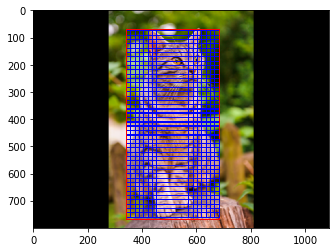

torch.Size([1, 50, 68, 4])
torch.Size([3400, 4])
torch.Size([3400])
torch.Size([3400, 4])


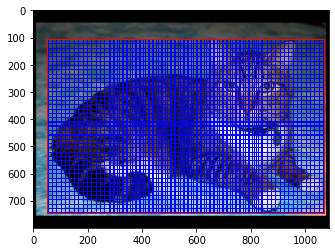

In [ ]:
for idx in range(2):

  # Flatten the ground truth and the anchors
  flatten_coord,flatten_gt,flatten_anchors = output_flattening(ground_coord[idx].unsqueeze(0),gt[idx].unsqueeze(0),rpn_net.get_anchors())
  print(flatten_coord.shape)
  print(flatten_gt.shape)
  print(flatten_anchors.shape)
  # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes
  decoded_coord, _ =output_decoding(flatten_coord,flatten_anchors)

  # Plot the image and the anchor boxes with the positive labels and their corresponding ground truth box
  # img = transforms.functional.normalize(images[idx],
  #                                               (-0.485, -0.456, -0.406),
  #                                               (1/0.229, 1/0.224, 1/0.225), inplace=False)
  transform = transforms.Compose([transforms.Normalize((-0.485, -0.456, -0.406), (1/0.229, 1/0.224, 1/0.225))])
  img = transform(images[idx])
  fig1,ax1 = plt.subplots(1,1)
  ax1.imshow(img.permute(1,2,0).data.long().cpu().numpy())

  find_cor=(flatten_gt==1).nonzero()
  find_neg=(flatten_gt==-1).nonzero()
        
  for elem in find_cor:
      coord=decoded_coord[elem,:].view(-1)
      anchor=flatten_anchors[elem,:].view(-1)
      # print(coord)
      col='r'
      
      for j in range(len(boxes[idx])):
        rect1=patches.Rectangle((boxes[idx][j][0],boxes[idx][j][1]),boxes[idx][j][2]-boxes[idx][j][0],boxes[idx][j][3]-boxes[idx][j][1],fill=False,color=col)
        ax1.add_patch(rect1)
      rect=patches.Rectangle((anchor[0]-anchor[2]/2,anchor[1]-anchor[3]/2),anchor[2],anchor[3],fill=False,color='b')
      ax1.add_patch(rect)
  plt.show()

# Training 

In [ ]:
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_MASKRCNN')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'MASKRCNN')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

In [ ]:
import tqdm

## Training Loop

In [ ]:
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_MASKRCNNRectified')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'MASKRCNN')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

In [ ]:
resume=False
if resume:
  path = '/content/gdrive/My Drive/CIS680_MASKRCNN/MASKRCNN/Result'+str(resume_epoch)
  checkpoint = torch.load(path)
  solo_head.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epochsdone = checkpoint['epoch']


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rpn_net = RPNHead().to(device)
learning_rate = 0.001
optimizer=torch.optim.Adam(rpn_net.parameters(),lr=learning_rate)
train_loss = 0
class_loss = 0
reg_loss = 0
overall_step = 0
classifier_loss_list = []
regressor_loss_list = []
total_loss_list = []
epoch_count = []
iteration = []
for epo in tqdm.tqdm(range(40)):
  rpn_net.train()
  for i,batch in enumerate(train_loader,0):
    overall_step +=1 
    images=batch['images']
    images=images.to(device)
    indexes=batch['index']
    boxes=batch['bbox']
    target_clas,target_ground_coord=rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:])
    optimizer.zero_grad()
    clas_out, regr_out = rpn_net.forward(images.float())
    classifier_loss,regressor_loss,total_loss = rpn_net.compute_loss(clas_out,regr_out,target_clas,target_ground_coord,1,200)
    total_loss.backward()
    optimizer.step()
    if overall_step %100 != 0:
      #print("Loading")
      train_loss += total_loss.item()
      class_loss += classifier_loss.item()
      reg_loss += regressor_loss.item()
    else:
      classifier_loss_list.append(class_loss/100)
      regressor_loss_list.append(reg_loss/100)
      total_loss_list.append(train_loss/100)
      train_loss = 0
      class_loss = 0
      reg_loss = 0
      iteration.append(overall_step)
      print("Epoch Count:{} | Iteration Count: {} | Total loss : {} | Classifier Loss: {} | Regression Loss: {}".format(epo,i+1,total_loss.item(),classifier_loss.item(),regressor_loss.item()))
  
  #print("Training Loss", train_loss / (i+1))
  #print("Epoch Count {} | Total Epoch Loss: {} | Classifier Epoch Loss: {} | Regression Epoch Loss: {}".format(epo,))
  print()
  path = '/content/gdrive/My Drive/CIS680_MASKRCNNRectified/MASKRCNN/Result'+str(epo)
  torch.save({\
              'epoch': epo+1,\
              'model_state_dict': rpn_net.state_dict(),\
              'optimizer_state_dict':optimizer.state_dict()\
              },path)


# def testing()





  0%|          | 0/40 [00:00<?, ?it/s]

Epoch Count:0 | Iteration Count: 100 | Total loss : 0.810167133808136 | Classifier Loss: 0.7398722767829895 | Regression Loss: 0.14058974385261536
Epoch Count:0 | Iteration Count: 200 | Total loss : 0.7718983292579651 | Classifier Loss: 0.7137377858161926 | Regression Loss: 0.11632104963064194
Epoch Count:0 | Iteration Count: 300 | Total loss : 0.7353196144104004 | Classifier Loss: 0.6734022498130798 | Regression Loss: 0.12383472174406052
Epoch Count:0 | Iteration Count: 400 | Total loss : 0.758370041847229 | Classifier Loss: 0.7001211643218994 | Regression Loss: 0.11649774014949799
Epoch Count:0 | Iteration Count: 500 | Total loss : 0.6626971364021301 | Classifier Loss: 0.6411265134811401 | Regression Loss: 0.04314126819372177
Epoch Count:0 | Iteration Count: 600 | Total loss : 0.7763727903366089 | Classifier Loss: 0.7387071251869202 | Regression Loss: 0.07533136755228043
Epoch Count:0 | Iteration Count: 700 | Total loss : 0.7396621704101562 | Classifier Loss: 0.7025386691093445 | Reg





  2%|▎         | 1/40 [1:07:45<44:02:24, 4065.25s/it]


Epoch Count:1 | Iteration Count: 94 | Total loss : 0.7976374626159668 | Classifier Loss: 0.7152642607688904 | Regression Loss: 0.16474643349647522
Epoch Count:1 | Iteration Count: 194 | Total loss : 0.7299630045890808 | Classifier Loss: 0.6976479291915894 | Regression Loss: 0.06463020294904709
Epoch Count:1 | Iteration Count: 294 | Total loss : 0.574061930179596 | Classifier Loss: 0.5674273371696472 | Regression Loss: 0.0737178698182106
Epoch Count:1 | Iteration Count: 394 | Total loss : 0.6438711881637573 | Classifier Loss: 0.6205032467842102 | Regression Loss: 0.046735890209674835
Epoch Count:1 | Iteration Count: 494 | Total loss : 0.6407120823860168 | Classifier Loss: 0.6121060848236084 | Regression Loss: 0.057211969047784805
Epoch Count:1 | Iteration Count: 594 | Total loss : 0.6399398446083069 | Classifier Loss: 0.5627343058586121 | Regression Loss: 0.15441107749938965
Epoch Count:1 | Iteration Count: 694 | Total loss : 0.7429575324058533 | Classifier Loss: 0.71480393409729 | Reg





  5%|▌         | 2/40 [1:11:27<30:44:26, 2912.29s/it]


Epoch Count:2 | Iteration Count: 88 | Total loss : 0.8029892444610596 | Classifier Loss: 0.766447901725769 | Regression Loss: 0.07308268547058105
Epoch Count:2 | Iteration Count: 188 | Total loss : 0.7336094379425049 | Classifier Loss: 0.7040961384773254 | Regression Loss: 0.0590265728533268
Epoch Count:2 | Iteration Count: 288 | Total loss : 0.8193584084510803 | Classifier Loss: 0.6507409811019897 | Regression Loss: 0.449646532535553
Epoch Count:2 | Iteration Count: 388 | Total loss : 0.6203356385231018 | Classifier Loss: 0.58831387758255 | Regression Loss: 0.28463804721832275
Epoch Count:2 | Iteration Count: 488 | Total loss : 0.6999944448471069 | Classifier Loss: 0.656806468963623 | Regression Loss: 0.08637593686580658
Epoch Count:2 | Iteration Count: 588 | Total loss : 0.8459166884422302 | Classifier Loss: 0.8227904438972473 | Regression Loss: 0.04625249654054642
Epoch Count:2 | Iteration Count: 688 | Total loss : 0.7907153367996216 | Classifier Loss: 0.7261785864830017 | Regressi





  8%|▊         | 3/40 [1:15:09<21:38:12, 2105.21s/it]


Epoch Count:3 | Iteration Count: 82 | Total loss : 0.6630597710609436 | Classifier Loss: 0.6312764286994934 | Regression Loss: 0.06356663256883621
Epoch Count:3 | Iteration Count: 182 | Total loss : 0.5370234251022339 | Classifier Loss: 0.4730871617794037 | Regression Loss: 0.12787257134914398
Epoch Count:3 | Iteration Count: 282 | Total loss : 0.9232285022735596 | Classifier Loss: 0.8802049160003662 | Regression Loss: 0.08604718744754791
Epoch Count:3 | Iteration Count: 382 | Total loss : 0.5897703170776367 | Classifier Loss: 0.5571418404579163 | Regression Loss: 0.0652570053935051
Epoch Count:3 | Iteration Count: 482 | Total loss : 0.6504477262496948 | Classifier Loss: 0.6034642457962036 | Regression Loss: 0.09396697580814362
Epoch Count:3 | Iteration Count: 582 | Total loss : 0.49288123846054077 | Classifier Loss: 0.4517466127872467 | Regression Loss: 0.08226924389600754
Epoch Count:3 | Iteration Count: 682 | Total loss : 0.6247941851615906 | Classifier Loss: 0.5343651175498962 | R





 10%|█         | 4/40 [1:18:51<15:24:07, 1540.20s/it]


Epoch Count:4 | Iteration Count: 76 | Total loss : 0.6035606861114502 | Classifier Loss: 0.5137643814086914 | Regression Loss: 0.17959266901016235
Epoch Count:4 | Iteration Count: 176 | Total loss : 0.5789728164672852 | Classifier Loss: 0.5425876379013062 | Regression Loss: 0.11643259972333908
Epoch Count:4 | Iteration Count: 276 | Total loss : 0.556268572807312 | Classifier Loss: 0.4988328516483307 | Regression Loss: 0.11487139761447906
Epoch Count:4 | Iteration Count: 376 | Total loss : 0.5611223578453064 | Classifier Loss: 0.5549546480178833 | Regression Loss: 0.024187106639146805
Epoch Count:4 | Iteration Count: 476 | Total loss : 0.8698492050170898 | Classifier Loss: 0.8360543847084045 | Regression Loss: 0.067589670419693
Epoch Count:4 | Iteration Count: 576 | Total loss : 0.407185822725296 | Classifier Loss: 0.40063002705574036 | Regression Loss: 0.038563504815101624
Epoch Count:4 | Iteration Count: 676 | Total loss : 0.6033269762992859 | Classifier Loss: 0.5915821194648743 | Re





 12%|█▎        | 5/40 [1:22:32<11:07:42, 1144.64s/it]


Epoch Count:5 | Iteration Count: 70 | Total loss : 0.5948566794395447 | Classifier Loss: 0.5098723769187927 | Regression Loss: 0.18178460001945496
Epoch Count:5 | Iteration Count: 170 | Total loss : 0.5328084826469421 | Classifier Loss: 0.5238060355186462 | Regression Loss: 0.12003246694803238
Epoch Count:5 | Iteration Count: 270 | Total loss : 0.5635921359062195 | Classifier Loss: 0.521385133266449 | Regression Loss: 0.08441400527954102
Epoch Count:5 | Iteration Count: 370 | Total loss : 0.5398575663566589 | Classifier Loss: 0.5201854109764099 | Regression Loss: 0.10219305008649826
Epoch Count:5 | Iteration Count: 470 | Total loss : 0.5217201709747314 | Classifier Loss: 0.4899664521217346 | Regression Loss: 0.13957689702510834
Epoch Count:5 | Iteration Count: 570 | Total loss : 0.42461585998535156 | Classifier Loss: 0.4186984896659851 | Regression Loss: 0.03817649185657501
Epoch Count:5 | Iteration Count: 670 | Total loss : 0.39892810583114624 | Classifier Loss: 0.38284674286842346 |





 15%|█▌        | 6/40 [1:26:14<8:11:45, 867.81s/it]  


Epoch Count:6 | Iteration Count: 64 | Total loss : 0.6187177300453186 | Classifier Loss: 0.5280612111091614 | Regression Loss: 0.38171160221099854
Epoch Count:6 | Iteration Count: 164 | Total loss : 0.6586987376213074 | Classifier Loss: 0.6235610246658325 | Regression Loss: 0.07027541100978851
Epoch Count:6 | Iteration Count: 264 | Total loss : 0.6426181793212891 | Classifier Loss: 0.5548949241638184 | Regression Loss: 0.17544645071029663
Epoch Count:6 | Iteration Count: 364 | Total loss : 0.597025454044342 | Classifier Loss: 0.5385477542877197 | Regression Loss: 0.11695539206266403
Epoch Count:6 | Iteration Count: 464 | Total loss : 0.5633337497711182 | Classifier Loss: 0.479033499956131 | Regression Loss: 0.36258164048194885
Epoch Count:6 | Iteration Count: 564 | Total loss : 0.5451164245605469 | Classifier Loss: 0.49338826537132263 | Regression Loss: 0.1034562736749649
Epoch Count:6 | Iteration Count: 664 | Total loss : 0.5118284225463867 | Classifier Loss: 0.5014864206314087 | Reg





 18%|█▊        | 7/40 [1:29:56<6:10:40, 673.96s/it]


Epoch Count:7 | Iteration Count: 58 | Total loss : 0.4470895528793335 | Classifier Loss: 0.43681514263153076 | Regression Loss: 0.05268929526209831
Epoch Count:7 | Iteration Count: 158 | Total loss : 0.5545873641967773 | Classifier Loss: 0.5397442579269409 | Regression Loss: 0.04749784618616104
Epoch Count:7 | Iteration Count: 258 | Total loss : 0.6470822691917419 | Classifier Loss: 0.6129977107048035 | Regression Loss: 0.06816906481981277
Epoch Count:7 | Iteration Count: 358 | Total loss : 0.5446622371673584 | Classifier Loss: 0.4922957420349121 | Regression Loss: 0.10473302006721497
Epoch Count:7 | Iteration Count: 458 | Total loss : 0.5625271201133728 | Classifier Loss: 0.5004205703735352 | Regression Loss: 0.12421304732561111
Epoch Count:7 | Iteration Count: 558 | Total loss : 0.7057002186775208 | Classifier Loss: 0.6119985580444336 | Regression Loss: 0.1874033659696579
Epoch Count:7 | Iteration Count: 658 | Total loss : 0.5841560959815979 | Classifier Loss: 0.524937093257904 | Re





 20%|██        | 8/40 [1:33:37<4:47:03, 538.23s/it]


Epoch Count:8 | Iteration Count: 52 | Total loss : 0.5949004292488098 | Classifier Loss: 0.5506936311721802 | Regression Loss: 0.08841358125209808
Epoch Count:8 | Iteration Count: 152 | Total loss : 0.6762259006500244 | Classifier Loss: 0.6447581052780151 | Regression Loss: 0.06293564289808273
Epoch Count:8 | Iteration Count: 252 | Total loss : 0.7292008996009827 | Classifier Loss: 0.6743516325950623 | Regression Loss: 0.10969854146242142
Epoch Count:8 | Iteration Count: 352 | Total loss : 0.47420820593833923 | Classifier Loss: 0.4544050395488739 | Regression Loss: 0.20310936868190765
Epoch Count:8 | Iteration Count: 452 | Total loss : 0.48766154050827026 | Classifier Loss: 0.46472182869911194 | Regression Loss: 0.04587940126657486
Epoch Count:8 | Iteration Count: 552 | Total loss : 0.5155682563781738 | Classifier Loss: 0.5035592317581177 | Regression Loss: 0.024018069729208946
Epoch Count:8 | Iteration Count: 652 | Total loss : 0.6995099186897278 | Classifier Loss: 0.6770366430282593





 22%|██▎       | 9/40 [1:37:19<3:49:02, 443.29s/it]


Epoch Count:9 | Iteration Count: 46 | Total loss : 0.4440923035144806 | Classifier Loss: 0.41554296016693115 | Regression Loss: 0.05709870159626007
Epoch Count:9 | Iteration Count: 146 | Total loss : 0.7559484243392944 | Classifier Loss: 0.6695031523704529 | Regression Loss: 0.1728905886411667
Epoch Count:9 | Iteration Count: 246 | Total loss : 0.5947054624557495 | Classifier Loss: 0.5843729376792908 | Regression Loss: 0.06262144446372986
Epoch Count:9 | Iteration Count: 346 | Total loss : 0.7610706090927124 | Classifier Loss: 0.7250933051109314 | Regression Loss: 0.07195460796356201
Epoch Count:9 | Iteration Count: 446 | Total loss : 0.6539604663848877 | Classifier Loss: 0.5993848443031311 | Regression Loss: 0.1091512069106102
Epoch Count:9 | Iteration Count: 546 | Total loss : 0.9798235297203064 | Classifier Loss: 0.9319390058517456 | Regression Loss: 0.09576903283596039
Epoch Count:9 | Iteration Count: 646 | Total loss : 0.7302745580673218 | Classifier Loss: 0.6552628874778748 | Re





 25%|██▌       | 10/40 [1:41:01<3:08:29, 376.97s/it]


Epoch Count:10 | Iteration Count: 40 | Total loss : 0.9823082685470581 | Classifier Loss: 0.9163184762001038 | Regression Loss: 0.1319795548915863
Epoch Count:10 | Iteration Count: 140 | Total loss : 0.5795964002609253 | Classifier Loss: 0.5485982298851013 | Regression Loss: 0.06199629604816437
Epoch Count:10 | Iteration Count: 240 | Total loss : 0.5882260203361511 | Classifier Loss: 0.5357946753501892 | Regression Loss: 0.10486269742250443
Epoch Count:10 | Iteration Count: 340 | Total loss : 0.28385603427886963 | Classifier Loss: 0.2807069420814514 | Regression Loss: 0.08997363597154617
Epoch Count:10 | Iteration Count: 440 | Total loss : 0.8069753050804138 | Classifier Loss: 0.7717576622962952 | Regression Loss: 0.07043524831533432
Epoch Count:10 | Iteration Count: 540 | Total loss : 0.43396809697151184 | Classifier Loss: 0.4102153182029724 | Regression Loss: 0.04750553146004677
Epoch Count:10 | Iteration Count: 640 | Total loss : 0.5075024366378784 | Classifier Loss: 0.467649668455





 28%|██▊       | 11/40 [1:44:44<2:39:49, 330.66s/it]


Epoch Count:11 | Iteration Count: 34 | Total loss : 0.4789409041404724 | Classifier Loss: 0.46562856435775757 | Regression Loss: 0.04840856045484543
Epoch Count:11 | Iteration Count: 134 | Total loss : 0.5439426898956299 | Classifier Loss: 0.5130395293235779 | Regression Loss: 0.11885825544595718
Epoch Count:11 | Iteration Count: 234 | Total loss : 0.8522310256958008 | Classifier Loss: 0.7921736240386963 | Regression Loss: 0.12011481076478958
Epoch Count:11 | Iteration Count: 334 | Total loss : 0.5090832710266113 | Classifier Loss: 0.46101537346839905 | Regression Loss: 0.09613585472106934
Epoch Count:11 | Iteration Count: 434 | Total loss : 0.7839043736457825 | Classifier Loss: 0.7487013339996338 | Regression Loss: 0.07040609419345856
Epoch Count:11 | Iteration Count: 534 | Total loss : 0.8445498943328857 | Classifier Loss: 0.7908086776733398 | Regression Loss: 0.10748244822025299
Epoch Count:11 | Iteration Count: 634 | Total loss : 0.7161580920219421 | Classifier Loss: 0.68837040662





 30%|███       | 12/40 [1:48:26<2:19:06, 298.10s/it]


Epoch Count:12 | Iteration Count: 28 | Total loss : 0.882737398147583 | Classifier Loss: 0.8016386032104492 | Regression Loss: 0.1621975600719452
Epoch Count:12 | Iteration Count: 128 | Total loss : 0.6471015214920044 | Classifier Loss: 0.5769537687301636 | Regression Loss: 0.14029556512832642
Epoch Count:12 | Iteration Count: 228 | Total loss : 0.7659213542938232 | Classifier Loss: 0.7243868708610535 | Regression Loss: 0.1161804348230362
Epoch Count:12 | Iteration Count: 328 | Total loss : 0.39708593487739563 | Classifier Loss: 0.35797256231307983 | Regression Loss: 0.07822676748037338
Epoch Count:12 | Iteration Count: 428 | Total loss : 1.0107630491256714 | Classifier Loss: 0.9479110240936279 | Regression Loss: 0.12570413947105408
Epoch Count:12 | Iteration Count: 528 | Total loss : 0.9619098901748657 | Classifier Loss: 0.8854106068611145 | Regression Loss: 0.15299852192401886
Epoch Count:12 | Iteration Count: 628 | Total loss : 0.49684783816337585 | Classifier Loss: 0.4547609686851





 32%|███▎      | 13/40 [1:52:09<2:03:57, 275.47s/it]


Epoch Count:13 | Iteration Count: 22 | Total loss : 0.9841046929359436 | Classifier Loss: 0.8865742087364197 | Regression Loss: 0.19506095349788666
Epoch Count:13 | Iteration Count: 122 | Total loss : 0.543630838394165 | Classifier Loss: 0.48433202505111694 | Regression Loss: 0.1185975968837738
Epoch Count:13 | Iteration Count: 222 | Total loss : 0.6856070756912231 | Classifier Loss: 0.6524050235748291 | Regression Loss: 0.0664040595293045
Epoch Count:13 | Iteration Count: 322 | Total loss : 0.5149065852165222 | Classifier Loss: 0.4893401861190796 | Regression Loss: 0.05113276466727257
Epoch Count:13 | Iteration Count: 422 | Total loss : 0.5114599466323853 | Classifier Loss: 0.45715922117233276 | Regression Loss: 0.15083542466163635
Epoch Count:13 | Iteration Count: 522 | Total loss : 0.5930126309394836 | Classifier Loss: 0.5482450723648071 | Regression Loss: 0.17729730904102325
Epoch Count:13 | Iteration Count: 622 | Total loss : 0.6721522808074951 | Classifier Loss: 0.59394460916519





 35%|███▌      | 14/40 [1:55:51<1:52:27, 259.51s/it]


Epoch Count:14 | Iteration Count: 16 | Total loss : 0.6543955206871033 | Classifier Loss: 0.6033435463905334 | Regression Loss: 0.10210397839546204
Epoch Count:14 | Iteration Count: 116 | Total loss : 0.45039552450180054 | Classifier Loss: 0.4246126413345337 | Regression Loss: 0.12425483018159866
Epoch Count:14 | Iteration Count: 216 | Total loss : 0.8180937767028809 | Classifier Loss: 0.7857275009155273 | Regression Loss: 0.0647326111793518
Epoch Count:14 | Iteration Count: 316 | Total loss : 0.3293898105621338 | Classifier Loss: 0.3142133057117462 | Regression Loss: 0.04186620935797691
Epoch Count:14 | Iteration Count: 416 | Total loss : 0.31915292143821716 | Classifier Loss: 0.2777368128299713 | Regression Loss: 0.08283223956823349
Epoch Count:14 | Iteration Count: 516 | Total loss : 0.7350391149520874 | Classifier Loss: 0.6547868251800537 | Regression Loss: 0.16050463914871216
Epoch Count:14 | Iteration Count: 616 | Total loss : 0.5717623829841614 | Classifier Loss: 0.514761626720





 38%|███▊      | 15/40 [1:59:33<1:43:29, 248.39s/it]


Epoch Count:15 | Iteration Count: 10 | Total loss : 0.6584420800209045 | Classifier Loss: 0.5990949273109436 | Regression Loss: 0.11869435757398605
Epoch Count:15 | Iteration Count: 110 | Total loss : 0.5964313745498657 | Classifier Loss: 0.5274826884269714 | Regression Loss: 0.13789740204811096
Epoch Count:15 | Iteration Count: 210 | Total loss : 0.6359983086585999 | Classifier Loss: 0.598308265209198 | Regression Loss: 0.0753801241517067
Epoch Count:15 | Iteration Count: 310 | Total loss : 0.6161187887191772 | Classifier Loss: 0.5478466153144836 | Regression Loss: 0.136544331908226
Epoch Count:15 | Iteration Count: 410 | Total loss : 0.49803993105888367 | Classifier Loss: 0.469399631023407 | Regression Loss: 0.05728059634566307
Epoch Count:15 | Iteration Count: 510 | Total loss : 1.0324829816818237 | Classifier Loss: 0.9642422199249268 | Regression Loss: 0.13648153841495514
Epoch Count:15 | Iteration Count: 610 | Total loss : 0.4989149272441864 | Classifier Loss: 0.45267829298973083





 40%|████      | 16/40 [2:03:15<1:36:11, 240.46s/it]


Epoch Count:16 | Iteration Count: 4 | Total loss : 0.6280717253684998 | Classifier Loss: 0.6091846823692322 | Regression Loss: 0.037774037569761276
Epoch Count:16 | Iteration Count: 104 | Total loss : 0.647780179977417 | Classifier Loss: 0.5737771987915039 | Regression Loss: 0.22770141065120697
Epoch Count:16 | Iteration Count: 204 | Total loss : 0.38684940338134766 | Classifier Loss: 0.37272873520851135 | Regression Loss: 0.09413768351078033
Epoch Count:16 | Iteration Count: 304 | Total loss : 0.6031966209411621 | Classifier Loss: 0.5709108710289001 | Regression Loss: 0.0645715519785881
Epoch Count:16 | Iteration Count: 404 | Total loss : 0.4454333186149597 | Classifier Loss: 0.4023910164833069 | Regression Loss: 0.08608461171388626
Epoch Count:16 | Iteration Count: 504 | Total loss : 0.5781233906745911 | Classifier Loss: 0.5404748320579529 | Regression Loss: 0.07529709488153458
Epoch Count:16 | Iteration Count: 604 | Total loss : 0.7524347305297852 | Classifier Loss: 0.7219253182411





 42%|████▎     | 17/40 [2:06:57<1:29:58, 234.74s/it]


Epoch Count:17 | Iteration Count: 98 | Total loss : 0.5131841897964478 | Classifier Loss: 0.4944673776626587 | Regression Loss: 0.20234371721744537
Epoch Count:17 | Iteration Count: 198 | Total loss : 0.6140743494033813 | Classifier Loss: 0.5889438986778259 | Regression Loss: 0.05026094242930412
Epoch Count:17 | Iteration Count: 298 | Total loss : 0.648162305355072 | Classifier Loss: 0.5998744964599609 | Regression Loss: 0.09657557308673859
Epoch Count:17 | Iteration Count: 398 | Total loss : 0.4967612028121948 | Classifier Loss: 0.42694923281669617 | Regression Loss: 0.13962391018867493
Epoch Count:17 | Iteration Count: 498 | Total loss : 0.7489913702011108 | Classifier Loss: 0.7279199957847595 | Regression Loss: 0.06584805250167847
Epoch Count:17 | Iteration Count: 598 | Total loss : 0.34827086329460144 | Classifier Loss: 0.3071303963661194 | Regression Loss: 0.08228091895580292
Epoch Count:17 | Iteration Count: 698 | Total loss : 0.6056041717529297 | Classifier Loss: 0.569689571857





 45%|████▌     | 18/40 [2:10:39<1:24:40, 230.92s/it]


Epoch Count:18 | Iteration Count: 92 | Total loss : 0.4074455201625824 | Classifier Loss: 0.388621062040329 | Regression Loss: 0.11408761143684387
Epoch Count:18 | Iteration Count: 192 | Total loss : 0.6917359232902527 | Classifier Loss: 0.6844633221626282 | Regression Loss: 0.13222940266132355
Epoch Count:18 | Iteration Count: 292 | Total loss : 0.6589596271514893 | Classifier Loss: 0.6080701947212219 | Regression Loss: 0.10177886486053467
Epoch Count:18 | Iteration Count: 392 | Total loss : 0.6389212608337402 | Classifier Loss: 0.6037964224815369 | Regression Loss: 0.07024972140789032
Epoch Count:18 | Iteration Count: 492 | Total loss : 0.6864708065986633 | Classifier Loss: 0.6500677466392517 | Regression Loss: 0.07280617207288742
Epoch Count:18 | Iteration Count: 592 | Total loss : 0.4705137610435486 | Classifier Loss: 0.4616723656654358 | Regression Loss: 0.025627244263887405
Epoch Count:18 | Iteration Count: 692 | Total loss : 0.5244972705841064 | Classifier Loss: 0.4716298878192





 48%|████▊     | 19/40 [2:14:22<1:19:58, 228.51s/it]


Epoch Count:19 | Iteration Count: 86 | Total loss : 0.45357510447502136 | Classifier Loss: 0.38996565341949463 | Regression Loss: 0.12721890211105347
Epoch Count:19 | Iteration Count: 186 | Total loss : 0.670964241027832 | Classifier Loss: 0.578196108341217 | Regression Loss: 0.3500683903694153
Epoch Count:19 | Iteration Count: 286 | Total loss : 0.6402020454406738 | Classifier Loss: 0.6102309226989746 | Regression Loss: 0.059942204505205154
Epoch Count:19 | Iteration Count: 386 | Total loss : 0.6966663002967834 | Classifier Loss: 0.6539031863212585 | Regression Loss: 0.0855262279510498
Epoch Count:19 | Iteration Count: 486 | Total loss : 0.43650147318840027 | Classifier Loss: 0.4277450144290924 | Regression Loss: 0.08339497447013855
Epoch Count:19 | Iteration Count: 586 | Total loss : 0.44177448749542236 | Classifier Loss: 0.3743666112422943 | Regression Loss: 0.1809607893228531
Epoch Count:19 | Iteration Count: 686 | Total loss : 0.7096220254898071 | Classifier Loss: 0.6364623904228





 50%|█████     | 20/40 [2:18:04<1:15:35, 226.79s/it]


Epoch Count:20 | Iteration Count: 80 | Total loss : 0.40810197591781616 | Classifier Loss: 0.39963942766189575 | Regression Loss: 0.19911882281303406
Epoch Count:20 | Iteration Count: 180 | Total loss : 0.6398048996925354 | Classifier Loss: 0.5958596467971802 | Regression Loss: 0.08789052069187164
Epoch Count:20 | Iteration Count: 280 | Total loss : 0.29683440923690796 | Classifier Loss: 0.29207006096839905 | Regression Loss: 0.040547680109739304
Epoch Count:20 | Iteration Count: 380 | Total loss : 0.37102317810058594 | Classifier Loss: 0.3149999678134918 | Regression Loss: 0.11204639822244644
Epoch Count:20 | Iteration Count: 480 | Total loss : 0.651116132736206 | Classifier Loss: 0.5935643315315247 | Regression Loss: 0.11510360240936279
Epoch Count:20 | Iteration Count: 580 | Total loss : 0.6922163963317871 | Classifier Loss: 0.667705774307251 | Regression Loss: 0.04902121424674988
Epoch Count:20 | Iteration Count: 680 | Total loss : 0.5015383958816528 | Classifier Loss: 0.462244570





 52%|█████▎    | 21/40 [2:21:47<1:11:26, 225.60s/it]


Epoch Count:21 | Iteration Count: 74 | Total loss : 0.5613585114479065 | Classifier Loss: 0.5435594320297241 | Regression Loss: 0.03559813275933266
Epoch Count:21 | Iteration Count: 174 | Total loss : 0.5571340918540955 | Classifier Loss: 0.5279960632324219 | Regression Loss: 0.058276012539863586
Epoch Count:21 | Iteration Count: 274 | Total loss : 0.3885137140750885 | Classifier Loss: 0.365265429019928 | Regression Loss: 0.04649655148386955
Epoch Count:21 | Iteration Count: 374 | Total loss : 0.7335007786750793 | Classifier Loss: 0.6513282060623169 | Regression Loss: 0.16434518992900848
Epoch Count:21 | Iteration Count: 474 | Total loss : 0.523853063583374 | Classifier Loss: 0.47878360748291016 | Regression Loss: 0.09013885259628296
Epoch Count:21 | Iteration Count: 574 | Total loss : 0.4329775869846344 | Classifier Loss: 0.40048980712890625 | Regression Loss: 0.0649755522608757
Epoch Count:21 | Iteration Count: 674 | Total loss : 0.6647252440452576 | Classifier Loss: 0.6344755291938





 55%|█████▌    | 22/40 [2:25:30<1:07:26, 224.80s/it]


Epoch Count:22 | Iteration Count: 68 | Total loss : 0.4633040428161621 | Classifier Loss: 0.3885275423526764 | Regression Loss: 0.14955301582813263
Epoch Count:22 | Iteration Count: 168 | Total loss : 0.28068166971206665 | Classifier Loss: 0.27809566259384155 | Regression Loss: 0.05444198474287987
Epoch Count:22 | Iteration Count: 268 | Total loss : 0.5268799066543579 | Classifier Loss: 0.4867616593837738 | Regression Loss: 0.19103939831256866
Epoch Count:22 | Iteration Count: 368 | Total loss : 0.6976017355918884 | Classifier Loss: 0.6796218752861023 | Regression Loss: 0.03595970198512077
Epoch Count:22 | Iteration Count: 468 | Total loss : 0.6893975734710693 | Classifier Loss: 0.6524560451507568 | Regression Loss: 0.3694153428077698
Epoch Count:22 | Iteration Count: 568 | Total loss : 0.8627046942710876 | Classifier Loss: 0.813339114189148 | Regression Loss: 0.09873117506504059
Epoch Count:22 | Iteration Count: 668 | Total loss : 0.6115557551383972 | Classifier Loss: 0.5495552420616





 57%|█████▊    | 23/40 [2:29:13<1:03:32, 224.29s/it]


Epoch Count:23 | Iteration Count: 62 | Total loss : 0.7277284860610962 | Classifier Loss: 0.6355324983596802 | Regression Loss: 0.18439200520515442
Epoch Count:23 | Iteration Count: 162 | Total loss : 0.4876554608345032 | Classifier Loss: 0.4543156623840332 | Regression Loss: 0.06667961180210114
Epoch Count:23 | Iteration Count: 262 | Total loss : 0.47125041484832764 | Classifier Loss: 0.44235074520111084 | Regression Loss: 0.05779934301972389
Epoch Count:23 | Iteration Count: 362 | Total loss : 0.5236232280731201 | Classifier Loss: 0.47492659091949463 | Regression Loss: 0.09739324450492859
Epoch Count:23 | Iteration Count: 462 | Total loss : 0.5869494676589966 | Classifier Loss: 0.5091973543167114 | Regression Loss: 0.1555042266845703
Epoch Count:23 | Iteration Count: 562 | Total loss : 0.5240145325660706 | Classifier Loss: 0.4787108600139618 | Regression Loss: 0.16474071145057678
Epoch Count:23 | Iteration Count: 662 | Total loss : 0.6383697986602783 | Classifier Loss: 0.55948907136





 60%|██████    | 24/40 [2:32:57<59:43, 223.98s/it]  


Epoch Count:24 | Iteration Count: 56 | Total loss : 0.4001200795173645 | Classifier Loss: 0.3601444661617279 | Regression Loss: 0.13215073943138123
Epoch Count:24 | Iteration Count: 156 | Total loss : 0.7880693674087524 | Classifier Loss: 0.7653000950813293 | Regression Loss: 0.045538585633039474
Epoch Count:24 | Iteration Count: 256 | Total loss : 0.6973914504051208 | Classifier Loss: 0.6737692952156067 | Regression Loss: 0.0472443662583828
Epoch Count:24 | Iteration Count: 356 | Total loss : 0.6231204271316528 | Classifier Loss: 0.5740522146224976 | Regression Loss: 0.09813638776540756
Epoch Count:24 | Iteration Count: 456 | Total loss : 0.6078212261199951 | Classifier Loss: 0.5694630742073059 | Regression Loss: 0.07671629637479782
Epoch Count:24 | Iteration Count: 556 | Total loss : 0.4339909553527832 | Classifier Loss: 0.4146832823753357 | Regression Loss: 0.13315632939338684
Epoch Count:24 | Iteration Count: 656 | Total loss : 0.5021639466285706 | Classifier Loss: 0.4804386794567





 62%|██████▎   | 25/40 [2:36:40<55:55, 223.70s/it]


Epoch Count:25 | Iteration Count: 50 | Total loss : 0.7573969960212708 | Classifier Loss: 0.7056340575218201 | Regression Loss: 0.10352588444948196
Epoch Count:25 | Iteration Count: 150 | Total loss : 0.43787336349487305 | Classifier Loss: 0.36884981393814087 | Regression Loss: 0.13804708421230316
Epoch Count:25 | Iteration Count: 250 | Total loss : 0.9146512150764465 | Classifier Loss: 0.8612263202667236 | Regression Loss: 0.10684975236654282
Epoch Count:25 | Iteration Count: 350 | Total loss : 0.6648212671279907 | Classifier Loss: 0.6472691297531128 | Regression Loss: 0.03510425612330437
Epoch Count:25 | Iteration Count: 450 | Total loss : 0.5216251611709595 | Classifier Loss: 0.5056511759757996 | Regression Loss: 0.10649308562278748
Epoch Count:25 | Iteration Count: 550 | Total loss : 0.6971387267112732 | Classifier Loss: 0.6397817134857178 | Regression Loss: 0.11471401154994965
Epoch Count:25 | Iteration Count: 650 | Total loss : 0.3552958369255066 | Classifier Loss: 0.34950032830





 65%|██████▌   | 26/40 [2:40:23<52:11, 223.67s/it]


Epoch Count:26 | Iteration Count: 44 | Total loss : 0.4054107367992401 | Classifier Loss: 0.3769828677177429 | Regression Loss: 0.05685575306415558
Epoch Count:26 | Iteration Count: 144 | Total loss : 0.5339760780334473 | Classifier Loss: 0.4504085183143616 | Regression Loss: 0.1671351194381714
Epoch Count:26 | Iteration Count: 244 | Total loss : 0.376042902469635 | Classifier Loss: 0.3335426151752472 | Regression Loss: 0.08500058948993683
Epoch Count:26 | Iteration Count: 344 | Total loss : 0.682646632194519 | Classifier Loss: 0.5834661722183228 | Regression Loss: 0.1983608901500702
Epoch Count:26 | Iteration Count: 444 | Total loss : 0.7196141481399536 | Classifier Loss: 0.6127731204032898 | Regression Loss: 0.21368205547332764
Epoch Count:26 | Iteration Count: 544 | Total loss : 0.6200427412986755 | Classifier Loss: 0.5476819276809692 | Regression Loss: 0.14618344604969025
Epoch Count:26 | Iteration Count: 644 | Total loss : 0.5744997262954712 | Classifier Loss: 0.5068292021751404 





 68%|██████▊   | 27/40 [2:44:07<48:27, 223.64s/it]


Epoch Count:27 | Iteration Count: 38 | Total loss : 0.37897011637687683 | Classifier Loss: 0.37192076444625854 | Regression Loss: 0.08056404441595078
Epoch Count:27 | Iteration Count: 138 | Total loss : 0.7019671201705933 | Classifier Loss: 0.6215776801109314 | Regression Loss: 0.16077888011932373
Epoch Count:27 | Iteration Count: 238 | Total loss : 0.45149022340774536 | Classifier Loss: 0.42126360535621643 | Regression Loss: 0.06045321002602577
Epoch Count:27 | Iteration Count: 338 | Total loss : 0.609228253364563 | Classifier Loss: 0.5763230919837952 | Regression Loss: 0.06581027805805206
Epoch Count:27 | Iteration Count: 438 | Total loss : 0.541570782661438 | Classifier Loss: 0.5024792551994324 | Regression Loss: 0.07818306982517242
Epoch Count:27 | Iteration Count: 538 | Total loss : 0.5745800733566284 | Classifier Loss: 0.5016829371452332 | Regression Loss: 0.14579424262046814
Epoch Count:27 | Iteration Count: 638 | Total loss : 0.6869919300079346 | Classifier Loss: 0.65294903516





 70%|███████   | 28/40 [2:47:51<44:45, 223.76s/it]


Epoch Count:28 | Iteration Count: 32 | Total loss : 0.414959192276001 | Classifier Loss: 0.38923215866088867 | Regression Loss: 0.09188231080770493
Epoch Count:28 | Iteration Count: 132 | Total loss : 0.42423704266548157 | Classifier Loss: 0.40488678216934204 | Regression Loss: 0.038700517266988754
Epoch Count:28 | Iteration Count: 232 | Total loss : 0.44420909881591797 | Classifier Loss: 0.4300590455532074 | Regression Loss: 0.047166891396045685
Epoch Count:28 | Iteration Count: 332 | Total loss : 0.5491845011711121 | Classifier Loss: 0.48673009872436523 | Regression Loss: 0.12490877509117126
Epoch Count:28 | Iteration Count: 432 | Total loss : 0.5994660258293152 | Classifier Loss: 0.5495452880859375 | Regression Loss: 0.09984150528907776
Epoch Count:28 | Iteration Count: 532 | Total loss : 0.5764780640602112 | Classifier Loss: 0.5418342351913452 | Regression Loss: 0.06928763538599014
Epoch Count:28 | Iteration Count: 632 | Total loss : 0.5505306124687195 | Classifier Loss: 0.4200688





 72%|███████▎  | 29/40 [2:51:36<41:04, 224.05s/it]


Epoch Count:29 | Iteration Count: 26 | Total loss : 0.534949779510498 | Classifier Loss: 0.503882884979248 | Regression Loss: 0.06213380768895149
Epoch Count:29 | Iteration Count: 126 | Total loss : 0.7475560307502747 | Classifier Loss: 0.6793296933174133 | Regression Loss: 0.13645267486572266
Epoch Count:29 | Iteration Count: 226 | Total loss : 0.4435179531574249 | Classifier Loss: 0.36447954177856445 | Regression Loss: 0.15807682275772095
Epoch Count:29 | Iteration Count: 326 | Total loss : 0.34658554196357727 | Classifier Loss: 0.33980903029441833 | Regression Loss: 0.06453827023506165
Epoch Count:29 | Iteration Count: 426 | Total loss : 1.0139540433883667 | Classifier Loss: 0.9551985859870911 | Regression Loss: 0.11751095205545425
Epoch Count:29 | Iteration Count: 526 | Total loss : 0.6203442811965942 | Classifier Loss: 0.5913190245628357 | Regression Loss: 0.05805046483874321
Epoch Count:29 | Iteration Count: 626 | Total loss : 0.6934717893600464 | Classifier Loss: 0.663508594036





 75%|███████▌  | 30/40 [2:55:20<37:21, 224.20s/it]


Epoch Count:30 | Iteration Count: 20 | Total loss : 0.7142367959022522 | Classifier Loss: 0.6845986843109131 | Regression Loss: 0.059276241809129715
Epoch Count:30 | Iteration Count: 120 | Total loss : 0.4791361093521118 | Classifier Loss: 0.4093557298183441 | Regression Loss: 0.1395607590675354
Epoch Count:30 | Iteration Count: 220 | Total loss : 0.36629146337509155 | Classifier Loss: 0.3578333258628845 | Regression Loss: 0.029419591650366783
Epoch Count:30 | Iteration Count: 320 | Total loss : 0.505375862121582 | Classifier Loss: 0.48635631799697876 | Regression Loss: 0.045284684747457504
Epoch Count:30 | Iteration Count: 420 | Total loss : 0.5514975786209106 | Classifier Loss: 0.4569151997566223 | Regression Loss: 0.23794305324554443
Epoch Count:30 | Iteration Count: 520 | Total loss : 0.5028185844421387 | Classifier Loss: 0.492115318775177 | Regression Loss: 0.09307163208723068
Epoch Count:30 | Iteration Count: 620 | Total loss : 0.5286219120025635 | Classifier Loss: 0.50830119848





 78%|███████▊  | 31/40 [2:59:04<33:37, 224.14s/it]


Epoch Count:31 | Iteration Count: 14 | Total loss : 0.44502827525138855 | Classifier Loss: 0.43340399861335754 | Regression Loss: 0.1256677210330963
Epoch Count:31 | Iteration Count: 114 | Total loss : 0.6728295683860779 | Classifier Loss: 0.6140725016593933 | Regression Loss: 0.11751417070627213
Epoch Count:31 | Iteration Count: 214 | Total loss : 0.6547614336013794 | Classifier Loss: 0.5916911959648132 | Regression Loss: 0.1261405199766159
Epoch Count:31 | Iteration Count: 314 | Total loss : 0.7995633482933044 | Classifier Loss: 0.7642558813095093 | Regression Loss: 0.07061491906642914
Epoch Count:31 | Iteration Count: 414 | Total loss : 0.5078777074813843 | Classifier Loss: 0.4827471673488617 | Regression Loss: 0.213876873254776
Epoch Count:31 | Iteration Count: 514 | Total loss : 0.538070023059845 | Classifier Loss: 0.5196407437324524 | Regression Loss: 0.054605282843112946
Epoch Count:31 | Iteration Count: 614 | Total loss : 0.208562433719635 | Classifier Loss: 0.1979998499155044





 80%|████████  | 32/40 [3:02:48<29:51, 223.91s/it]


Epoch Count:32 | Iteration Count: 8 | Total loss : 0.43526244163513184 | Classifier Loss: 0.42127111554145813 | Regression Loss: 0.25438758730888367
Epoch Count:32 | Iteration Count: 108 | Total loss : 0.4967662990093231 | Classifier Loss: 0.4703955352306366 | Regression Loss: 0.05274150148034096
Epoch Count:32 | Iteration Count: 208 | Total loss : 0.4475342333316803 | Classifier Loss: 0.41358205676078796 | Regression Loss: 0.06790436804294586
Epoch Count:32 | Iteration Count: 308 | Total loss : 0.49153295159339905 | Classifier Loss: 0.48260733485221863 | Regression Loss: 0.06736322492361069
Epoch Count:32 | Iteration Count: 408 | Total loss : 0.641755998134613 | Classifier Loss: 0.5863346457481384 | Regression Loss: 0.1108427345752716
Epoch Count:32 | Iteration Count: 508 | Total loss : 0.5354266166687012 | Classifier Loss: 0.5318244695663452 | Regression Loss: 0.09005362540483475
Epoch Count:32 | Iteration Count: 608 | Total loss : 0.7045778036117554 | Classifier Loss: 0.66756272315





 82%|████████▎ | 33/40 [3:06:31<26:07, 223.89s/it]


Epoch Count:33 | Iteration Count: 2 | Total loss : 0.4155276119709015 | Classifier Loss: 0.38914966583251953 | Regression Loss: 0.05275588855147362
Epoch Count:33 | Iteration Count: 102 | Total loss : 0.5024661421775818 | Classifier Loss: 0.4712647497653961 | Regression Loss: 0.09244856983423233
Epoch Count:33 | Iteration Count: 202 | Total loss : 0.3882886469364166 | Classifier Loss: 0.3734792172908783 | Regression Loss: 0.04387978836894035
Epoch Count:33 | Iteration Count: 302 | Total loss : 0.524052083492279 | Classifier Loss: 0.45181456208229065 | Regression Loss: 0.1444750428199768
Epoch Count:33 | Iteration Count: 402 | Total loss : 0.7009438872337341 | Classifier Loss: 0.6301664113998413 | Regression Loss: 0.14155496656894684
Epoch Count:33 | Iteration Count: 502 | Total loss : 0.5337542295455933 | Classifier Loss: 0.488952100276947 | Regression Loss: 0.0896042138338089
Epoch Count:33 | Iteration Count: 602 | Total loss : 0.860174834728241 | Classifier Loss: 0.8319618105888367 





 85%|████████▌ | 34/40 [3:10:15<22:23, 223.94s/it]


Epoch Count:34 | Iteration Count: 96 | Total loss : 0.5349143743515015 | Classifier Loss: 0.475463330745697 | Regression Loss: 0.11890210211277008
Epoch Count:34 | Iteration Count: 196 | Total loss : 0.593197226524353 | Classifier Loss: 0.5078197121620178 | Regression Loss: 0.17075499892234802
Epoch Count:34 | Iteration Count: 296 | Total loss : 0.49620500206947327 | Classifier Loss: 0.48529452085494995 | Regression Loss: 0.08081848174333572
Epoch Count:34 | Iteration Count: 396 | Total loss : 0.5058302283287048 | Classifier Loss: 0.4716704785823822 | Regression Loss: 0.06831950694322586
Epoch Count:34 | Iteration Count: 496 | Total loss : 0.3945772647857666 | Classifier Loss: 0.3765697479248047 | Regression Loss: 0.03601505607366562
Epoch Count:34 | Iteration Count: 596 | Total loss : 0.5731654167175293 | Classifier Loss: 0.5087960958480835 | Regression Loss: 0.1287386119365692
Epoch Count:34 | Iteration Count: 696 | Total loss : 0.5215524435043335 | Classifier Loss: 0.47098994255065





 88%|████████▊ | 35/40 [3:13:59<18:39, 223.93s/it]


Epoch Count:35 | Iteration Count: 90 | Total loss : 0.497252881526947 | Classifier Loss: 0.4663146138191223 | Regression Loss: 0.061876505613327026
Epoch Count:35 | Iteration Count: 190 | Total loss : 0.373695433139801 | Classifier Loss: 0.36577048897743225 | Regression Loss: 0.12192235887050629
Epoch Count:35 | Iteration Count: 290 | Total loss : 0.7131930589675903 | Classifier Loss: 0.6978858709335327 | Regression Loss: 0.030614404007792473
Epoch Count:35 | Iteration Count: 390 | Total loss : 0.83254474401474 | Classifier Loss: 0.743323028087616 | Regression Loss: 0.17844343185424805
Epoch Count:35 | Iteration Count: 490 | Total loss : 0.6986774802207947 | Classifier Loss: 0.6092641949653625 | Regression Loss: 0.17882657051086426
Epoch Count:35 | Iteration Count: 590 | Total loss : 0.61966472864151 | Classifier Loss: 0.5641406774520874 | Regression Loss: 0.1127391830086708
Epoch Count:35 | Iteration Count: 690 | Total loss : 0.673957347869873 | Classifier Loss: 0.6369527578353882 | 





 90%|█████████ | 36/40 [3:17:43<14:55, 223.94s/it]


Epoch Count:36 | Iteration Count: 84 | Total loss : 0.4582796096801758 | Classifier Loss: 0.3856593668460846 | Regression Loss: 0.14524047076702118
Epoch Count:36 | Iteration Count: 184 | Total loss : 0.5802558064460754 | Classifier Loss: 0.5281671285629272 | Regression Loss: 0.10417737811803818
Epoch Count:36 | Iteration Count: 284 | Total loss : 0.23624344170093536 | Classifier Loss: 0.2294541895389557 | Regression Loss: 0.07339729368686676
Epoch Count:36 | Iteration Count: 384 | Total loss : 0.3490523099899292 | Classifier Loss: 0.3199743628501892 | Regression Loss: 0.058155886828899384
Epoch Count:36 | Iteration Count: 484 | Total loss : 0.33918488025665283 | Classifier Loss: 0.30645546317100525 | Regression Loss: 0.1081964373588562
Epoch Count:36 | Iteration Count: 584 | Total loss : 0.6028255820274353 | Classifier Loss: 0.49249640107154846 | Regression Loss: 0.2206583321094513
Epoch Count:36 | Iteration Count: 684 | Total loss : 0.6817066669464111 | Classifier Loss: 0.6105489134





 92%|█████████▎| 37/40 [3:21:27<11:11, 223.91s/it]


Epoch Count:37 | Iteration Count: 78 | Total loss : 0.64164137840271 | Classifier Loss: 0.6130496859550476 | Regression Loss: 0.25992465019226074
Epoch Count:37 | Iteration Count: 178 | Total loss : 0.7357434034347534 | Classifier Loss: 0.6728532910346985 | Regression Loss: 0.12578026950359344
Epoch Count:37 | Iteration Count: 278 | Total loss : 0.3759220838546753 | Classifier Loss: 0.33906397223472595 | Regression Loss: 0.07371621578931808
Epoch Count:37 | Iteration Count: 378 | Total loss : 0.8517943620681763 | Classifier Loss: 0.7812457084655762 | Regression Loss: 0.1410972625017166
Epoch Count:37 | Iteration Count: 478 | Total loss : 0.5435006022453308 | Classifier Loss: 0.4772722125053406 | Regression Loss: 0.13245679438114166
Epoch Count:37 | Iteration Count: 578 | Total loss : 0.4802146255970001 | Classifier Loss: 0.457646906375885 | Regression Loss: 0.045135434716939926
Epoch Count:37 | Iteration Count: 678 | Total loss : 0.45171621441841125 | Classifier Loss: 0.40251967310905





 95%|█████████▌| 38/40 [3:25:11<07:27, 223.91s/it]


Epoch Count:38 | Iteration Count: 72 | Total loss : 0.5476013422012329 | Classifier Loss: 0.44665610790252686 | Regression Loss: 0.20189043879508972
Epoch Count:38 | Iteration Count: 172 | Total loss : 0.48983901739120483 | Classifier Loss: 0.4689783453941345 | Regression Loss: 0.047681502997875214
Epoch Count:38 | Iteration Count: 272 | Total loss : 0.613521158695221 | Classifier Loss: 0.5822097063064575 | Regression Loss: 0.06262290477752686
Epoch Count:38 | Iteration Count: 372 | Total loss : 0.46903830766677856 | Classifier Loss: 0.3857318162918091 | Regression Loss: 0.16661299765110016
Epoch Count:38 | Iteration Count: 472 | Total loss : 0.449184775352478 | Classifier Loss: 0.42588409781455994 | Regression Loss: 0.04660138487815857
Epoch Count:38 | Iteration Count: 572 | Total loss : 0.7802671790122986 | Classifier Loss: 0.7258828282356262 | Regression Loss: 0.10876867175102234
Epoch Count:38 | Iteration Count: 672 | Total loss : 0.5332676768302917 | Classifier Loss: 0.4805308878





 98%|█████████▊| 39/40 [3:28:55<03:43, 223.93s/it]


Epoch Count:39 | Iteration Count: 66 | Total loss : 0.9112715125083923 | Classifier Loss: 0.8548519015312195 | Regression Loss: 0.1128392368555069
Epoch Count:39 | Iteration Count: 166 | Total loss : 0.3336113691329956 | Classifier Loss: 0.2880100905895233 | Regression Loss: 0.09702400118112564
Epoch Count:39 | Iteration Count: 266 | Total loss : 0.4588354229927063 | Classifier Loss: 0.397783488035202 | Regression Loss: 0.30912378430366516
Epoch Count:39 | Iteration Count: 366 | Total loss : 0.5328253507614136 | Classifier Loss: 0.4966209828853607 | Regression Loss: 0.27324074506759644
Epoch Count:39 | Iteration Count: 466 | Total loss : 0.4491265118122101 | Classifier Loss: 0.41911253333091736 | Regression Loss: 0.18758729100227356
Epoch Count:39 | Iteration Count: 566 | Total loss : 0.5935763716697693 | Classifier Loss: 0.5626162886619568 | Regression Loss: 0.06192022189497948
Epoch Count:39 | Iteration Count: 666 | Total loss : 0.4700646698474884 | Classifier Loss: 0.43737548589706





100%|██████████| 40/40 [3:32:39<00:00, 318.98s/it]

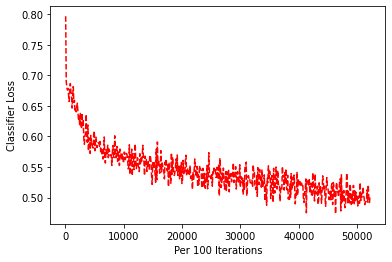

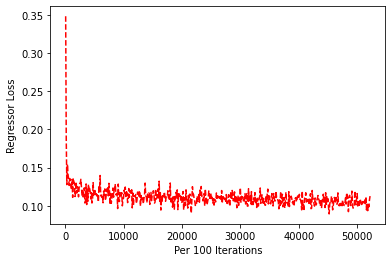

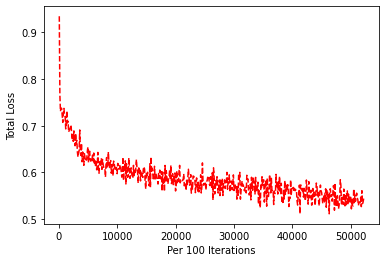

In [ ]:
import matplotlib.pyplot as plt
# classifier_loss_list = [i * 100 for i in classifier_loss_list]
# regressor_loss_list = [i * 100 for i in regressor_loss_list]
# total_loss_list = [i * 100 for i in total_loss_list]

plt.plot(iteration, classifier_loss_list, 'r--')
plt.xlabel('Per 100 Iterations')
plt.ylabel('Classifier Loss')
plt.show()
plt.plot(iteration, regressor_loss_list, 'r--')
plt.xlabel('Per 100 Iterations')
plt.ylabel('Regressor Loss')
plt.show()
plt.plot(iteration, total_loss_list, 'r--')
plt.xlabel('Per 100 Iterations')
plt.ylabel('Total Loss')
plt.show()

# Validation Plotting

In [ ]:
classifier_loss_list_test = []
regressor_loss_list_test = []
total_loss_list_test = []
epoch = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rpn_net = RPNHead().to(device)
optimizer=torch.optim.Adam(rpn_net.parameters(),lr=0.001)
for i in range(40):
  path = '/content/gdrive/My Drive/CIS680_MASKRCNNRectified/MASKRCNN/Result{}'.format(i)
  checkpoint = torch.load(path)
  rpn_net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  test_loss = 0
  class_loss_test = 0
  reg_loss_test = 0
  with torch.no_grad():
    rpn_net.eval()
    print()
    print("Testing Starts")
    print()
    for idx,batch_test in enumerate(test_loader,0):
      images=batch_test['images']
      images=images.to(device)
      indexes=batch_test['index']
      boxes=batch_test['bbox']
      if idx == 325:
        break
      target_clas,target_ground_coord=rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:])
      clas_out,regr_out=rpn_net.forward(images.float())
      classifier_loss,regressor_loss,total_loss = rpn_net.compute_loss(clas_out,regr_out,target_clas,target_ground_coord,1,200)
      test_loss += total_loss.item()
      class_loss_test += classifier_loss.item()
      reg_loss_test += regressor_loss.item()
  classifier_loss_list_test.append(class_loss_test/(idx+1))
  regressor_loss_list_test.append(reg_loss_test/(idx+1))
  total_loss_list_test.append(test_loss/(idx+1))
  epoch.append(idx)
  print("Testing Epoch Count:{}  | Total loss : {} | Classifier Loss: {} | Regression Loss: {}".format(i,test_loss/(idx+1),class_loss_test/(idx+1),reg_loss_test/(idx+1)))


Testing Starts

Testing Epoch Count:0  | Total loss : 0.7111681425498307 | Classifier Loss: 0.6614298206165524 | Regression Loss: 0.1284895633730146

Testing Starts

Testing Epoch Count:1  | Total loss : 0.7254894710391577 | Classifier Loss: 0.6749136441507222 | Regression Loss: 0.14708342677999311

Testing Starts

Testing Epoch Count:2  | Total loss : 0.6859918797125846 | Classifier Loss: 0.6390459343699589 | Regression Loss: 0.13104642125452223

Testing Starts

Testing Epoch Count:3  | Total loss : 0.7306874851507643 | Classifier Loss: 0.6821311125360383 | Regression Loss: 0.13471787443178837

Testing Starts

Testing Epoch Count:4  | Total loss : 0.6947441020169141 | Classifier Loss: 0.6482198794652347 | Regression Loss: 0.13029618490990136

Testing Starts

Testing Epoch Count:5  | Total loss : 0.7183406818315295 | Classifier Loss: 0.6712101990459887 | Regression Loss: 0.12837610265205793

Testing Starts

Testing Epoch Count:6  | Total loss : 0.6621624245965407 | Classifier Loss: 0.

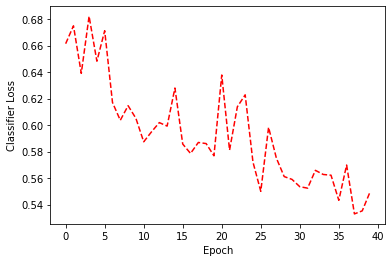

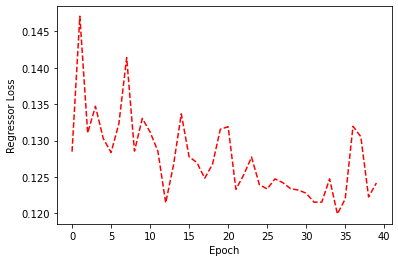

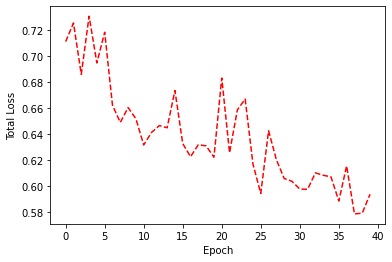

In [ ]:
import matplotlib.pyplot as plt

plt.plot(epc_count, classifier_loss_list_test, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Classifier Loss')
plt.show()
plt.plot(epc_count, regressor_loss_list_test, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Regressor Loss')
plt.show()
plt.plot(epc_count, total_loss_list_test, 'r--')
plt.xlabel('Epoch')
plt.ylabel('Total Loss')
plt.show()

## Point Accuracy over Test Data

In [ ]:
def point_accuracy(gt_anchor_labels, pred_anchor_labels):
  count_0 = 0
  count_1 = 0
  p_accuracy_1=0.0
  p_accuracy=0.0
  p_accuracy_2=0.0
  for i in range(50):
    for j in range(68):
      if (pred_anchor_labels[0][i][j]>=0.5 and gt_anchor_labels[0][i][j]==1):
        count_0+=1
      elif (pred_anchor_labels[0][i][j]<=0.5 and gt_anchor_labels[0][i][j]==0):
        count_0+=1
      elif (pred_anchor_labels[0][i][j]<=0.5 and gt_anchor_labels[0][i][j]==-1):
        count_0+=1
      if (pred_anchor_labels[1][i][j]>=0.5 and gt_anchor_labels[1][i][j]==1):
        count_1+=1
      elif (pred_anchor_labels[1]
            [i][j]<=0.5 and gt_anchor_labels[1][i][j]==0):
        count_1+=1
      elif (pred_anchor_labels[1][i][j]<=0.5 and gt_anchor_labels[1][i][j]==-1):
        count_1+=1
  p_accuracy_1=count_0/(50*68)
  p_accuracy_2=count_1/(50*68)
  p_accuracy = p_accuracy_1 + p_accuracy_2
  return p_accuracy

idx=0
pointwise_sum=0
rpn_net = RPNHead()
optimizer=torch.optim.Adam(rpn_net.parameters(),lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path = '/content/gdrive/My Drive/CIS680_MASKRCNNRectified/MASKRCNN/Result39'
checkpoint = torch.load(path)
rpn_net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
rpn_net=rpn_net.to(device)
with torch.no_grad():
  rpn_net.eval()
  # for iter, data in enumerate(test_loader, 0):
  for i,batch in enumerate(test_loader,0):
    if i == 325:
      break
    images=batch['images']
    images=images.cuda()
    indexes=batch['index']
    boxes=batch['bbox']
    #print("Index",i," ","Size of Box",boxes[0].shape,boxes[1].shape)
    target_clas,target_ground_coord=rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:])
    out_obj,out_bbox = rpn_net(images.float()) 
    target_clas = target_clas.squeeze(1)
    out_obj = out_obj.squeeze(1)
    pointwise_sum+=point_accuracy(target_clas.squeeze(0),out_obj.squeeze(0))
    idx+=1
print(pointwise_sum/idx)

Index 0   Size of Box (1, 4) (1, 4)
Index 1   Size of Box (2, 4) (2, 4)
Index 2   Size of Box (1, 4) (1, 4)
Index 3   Size of Box (1, 4) (1, 4)
Index 4   Size of Box (1, 4) (1, 4)
Index 5   Size of Box (1, 4) (1, 4)
Index 6   Size of Box (1, 4) (1, 4)
Index 7   Size of Box (1, 4) (1, 4)
Index 8   Size of Box (1, 4) (1, 4)
Index 9   Size of Box (1, 4) (1, 4)
Index 10   Size of Box (1, 4) (2, 4)
Index 11   Size of Box (1, 4) (1, 4)
Index 12   Size of Box (1, 4) (1, 4)
Index 13   Size of Box (2, 4) (2, 4)
Index 14   Size of Box (1, 4) (1, 4)
Index 15   Size of Box (1, 4) (2, 4)
Index 16   Size of Box (1, 4) (1, 4)
Index 17   Size of Box (2, 4) (1, 4)
Index 18   Size of Box (1, 4) (1, 4)
Index 19   Size of Box (1, 4) (1, 4)
Index 20   Size of Box (1, 4) (1, 4)
Index 21   Size of Box (1, 4) (1, 4)
Index 22   Size of Box (1, 4) (2, 4)
Index 23   Size of Box (1, 4) (1, 4)
Index 24   Size of Box (1, 4) (1, 4)
Index 25   Size of Box (2, 4) (1, 4)
Index 26   Size of Box (1, 4) (1, 4)
Index 27   

In [ ]:
avg_pointwise_accuracy = pointwise_sum/(idx*2)
print(avg_pointwise_accuracy)

0.8497443438914019


## Plotting from images in Test loader with top 20 boxes

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

rpn_net = RPNHead().to(device)
optimizer=torch.optim.Adam(rpn_net.parameters(),lr=0.001)
resume=True
if resume:
  path = '/content/Result38'
  checkpoint = torch.load(path)
  rpn_net.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epochsdone = checkpoint['epoch']

<Figure size 432x288 with 0 Axes>

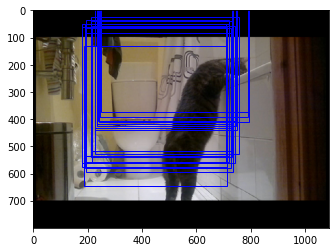

<Figure size 432x288 with 0 Axes>

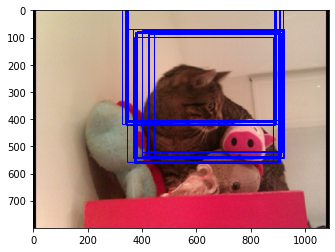

<Figure size 432x288 with 0 Axes>

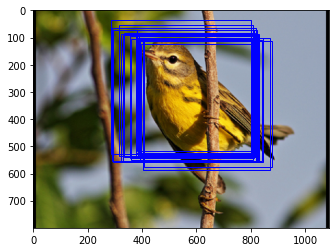

<Figure size 432x288 with 0 Axes>

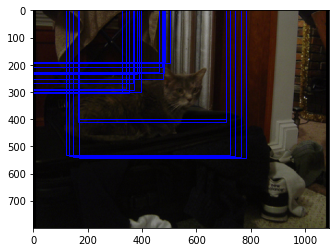

<Figure size 432x288 with 0 Axes>

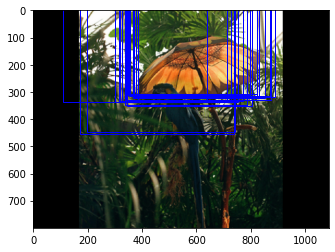

<Figure size 432x288 with 0 Axes>

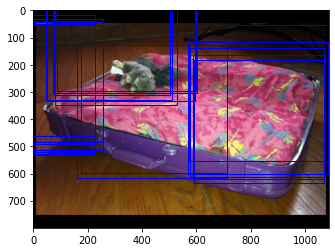

<Figure size 432x288 with 0 Axes>

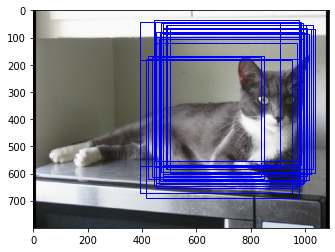

<Figure size 432x288 with 0 Axes>

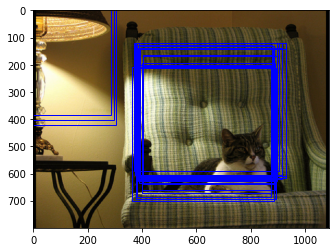

<Figure size 432x288 with 0 Axes>

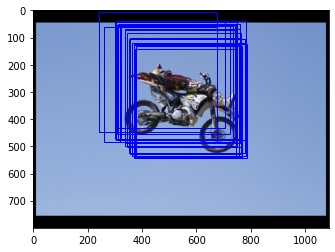

<Figure size 432x288 with 0 Axes>

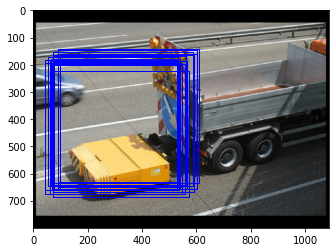

In [ ]:
for epo in tqdm.tqdm(range(10)):
  with torch.no_grad(): 
    rpn_net.eval()
    for i,batch in enumerate(test_loader,0):
      images=batch['images']
      images=images.to(device)
      indexes=batch['index']
      boxes=batch['bbox']

      # gt,ground_coord=rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:])
      out_c, out_r = rpn_net.forward(images.float())
      # nms_clas_list, nms_prebox_list = rpn_net.postprocess(out_c, out_r)

      for idx in range(2):

        # Flatten the ground truth and the anchors
        flatten_coord,flatten_gt,flatten_anchors = output_flattening(out_r[idx].unsqueeze(0),out_c[idx].unsqueeze(0),rpn_net.get_anchors())

        # # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes
        decoded_coord, decoded_corners = output_decoding(flatten_coord,flatten_anchors,device=device)


        # Plot the image and the anchor boxes with the positive labels and their corresponding ground truth box
        transform = transforms.Compose([transforms.Normalize((-0.485, -0.456, -0.406), (1/0.229, 1/0.224, 1/0.225))])
        img = transform(images[idx])
        fig1,ax1 = plt.subplots(1,1)
        ax1.imshow(img.permute(1,2,0).data.long().cpu().numpy())

        # top 20 boxes pre NMS

        find_cor = flatten_gt.view(-1).argsort(0,descending=True)
        f = find_cor[0:20]
        # find_neg = (flatten_gt < 0.3).nonzero()

        for j,elem in enumerate(f):
            # coord=decoded_coord[elem,:].view(-1)
            coord = decoded_coord[elem,:].view(-1)
            # anchor = flatten_anchors[elem,:].view(-1)

            col='r'
            
            rect=patches.Rectangle((coord[0]-coord[2]/2,coord[1]-coord[3]/2),coord[2],coord[3],fill=False,color='b')
            ax1.add_patch(rect)
        plt.show()

## Plotting pre NMS and post NMS

<Figure size 432x288 with 0 Axes>

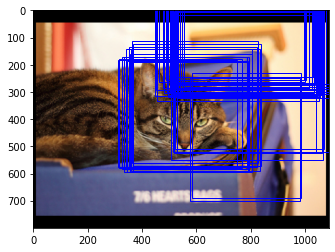

<Figure size 432x288 with 0 Axes>

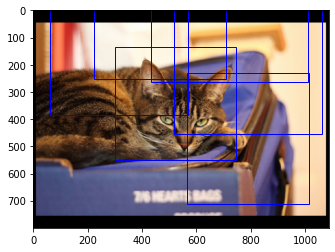

<Figure size 432x288 with 0 Axes>

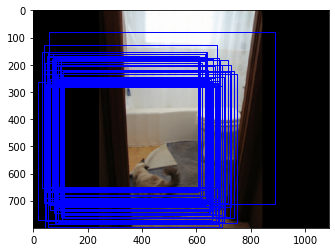

<Figure size 432x288 with 0 Axes>

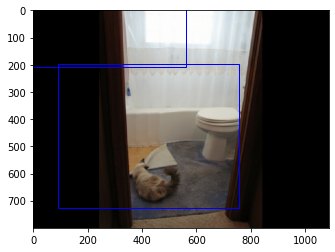

<Figure size 432x288 with 0 Axes>

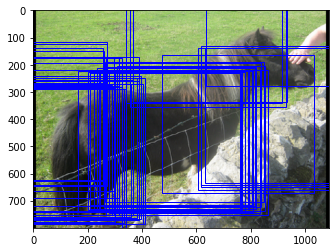

<Figure size 432x288 with 0 Axes>

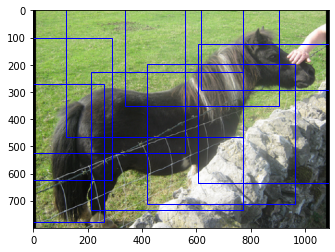

<Figure size 432x288 with 0 Axes>

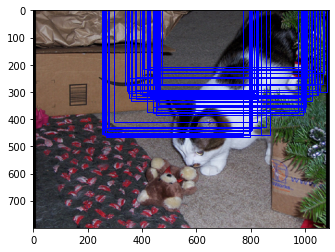

<Figure size 432x288 with 0 Axes>

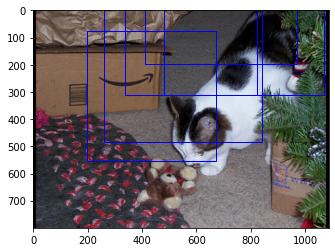

<Figure size 432x288 with 0 Axes>

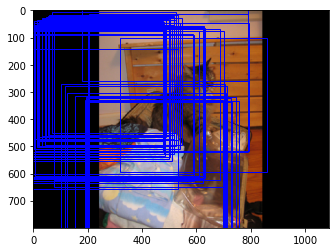

<Figure size 432x288 with 0 Axes>

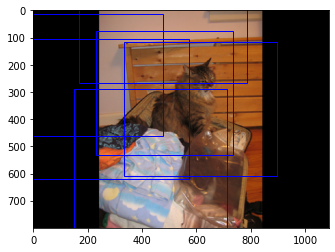

<Figure size 432x288 with 0 Axes>

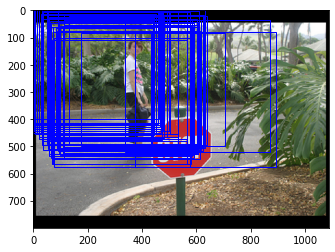

<Figure size 432x288 with 0 Axes>

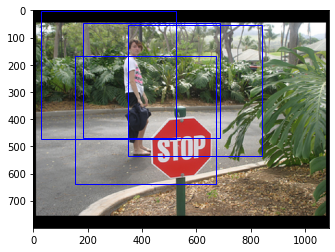

<Figure size 432x288 with 0 Axes>

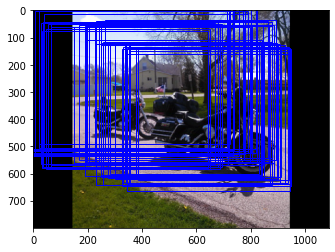

<Figure size 432x288 with 0 Axes>

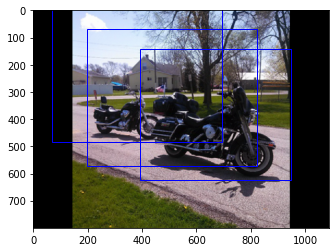

<Figure size 432x288 with 0 Axes>

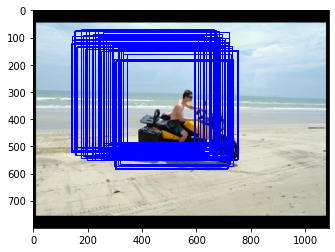

<Figure size 432x288 with 0 Axes>

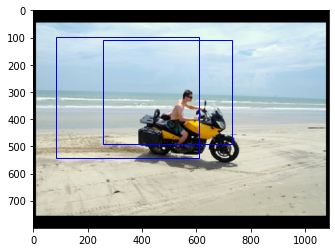

<Figure size 432x288 with 0 Axes>

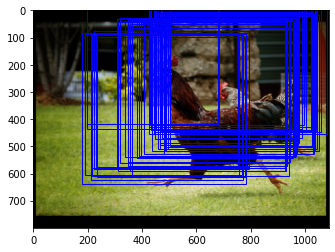

<Figure size 432x288 with 0 Axes>

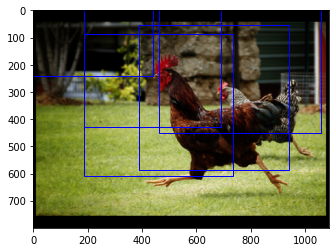

<Figure size 432x288 with 0 Axes>

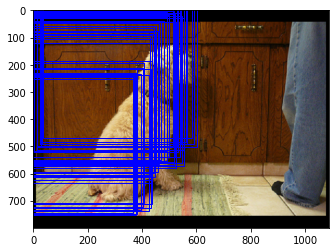

<Figure size 432x288 with 0 Axes>

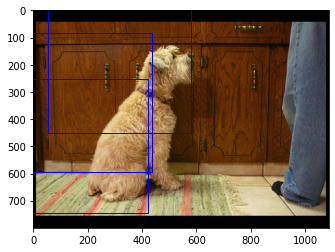

In [ ]:
for epo in tqdm.tqdm(range(10)):
  with torch.no_grad(): 
    rpn_net.eval()
    for i,batch in enumerate(test_loader,0):
      images=batch['images']
      images=images.to(device)
      indexes=batch['index']
      boxes=batch['bbox']

      # gt,ground_coord=rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:])
      out_c, out_r = rpn_net.forward(images.float())
      nms_clas_list, nms_prebox_list = rpn_net.postprocess(out_c, out_r)

      for idx in range(2):

        # Flatten the ground truth and the anchors
        flatten_coord,flatten_gt,flatten_anchors = output_flattening(out_r[idx].unsqueeze(0),out_c[idx].unsqueeze(0),rpn_net.get_anchors())

        # # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes
        decoded_coord, decoded_corners = output_decoding(flatten_coord,flatten_anchors,device=device)


        # Plot the image and the anchor boxes with the positive labels and their corresponding ground truth box
        transform = transforms.Compose([transforms.Normalize((-0.485, -0.456, -0.406), (1/0.229, 1/0.224, 1/0.225))])
        img = transform(images[idx])
        fig1,ax1 = plt.subplots(1,1)
        ax1.imshow(img.permute(1,2,0).data.long().cpu().numpy())

        # top 50 boxes pre NMS

        find_cor = flatten_gt.view(-1).argsort(0,descending=True)
        f = find_cor[0:50]
        # find_neg = (flatten_gt < 0.3).nonzero()

        for j,elem in enumerate(f):
            # coord=decoded_coord[elem,:].view(-1)
            coord = decoded_coord[elem,:].view(-1)
            # anchor = flatten_anchors[elem,:].view(-1)

            col='r'
            
            rect=patches.Rectangle((coord[0]-coord[2]/2,coord[1]-coord[3]/2),coord[2],coord[3],fill=False,color='b')
            ax1.add_patch(rect)
        
        fig1,ax2 = plt.subplots(1,1)
        ax2.imshow(img.permute(1,2,0).data.long().cpu().numpy())

        # top 5 boxes post NMS
        
        find_cor = nms_clas_list[idx]

        for j,elem in enumerate(find_cor):
  
            coord = nms_prebox_list[idx][j,:].view(-1)


            col='r'
            rect=patches.Rectangle((coord[0]-coord[2]/2,coord[1]-coord[3]/2),coord[2],coord[3],fill=False,color='b')
            ax2.add_patch(rect)
        plt.show()